In [7]:
import lightkurve as lk 
import matplotlib.pyplot as plt
import numpy as np

In [8]:
lcs = lk.search_lightcurve('HIP 67522', author='SPOC', exptime="120").download_all()
lcs = lcs[[0,1,3]]

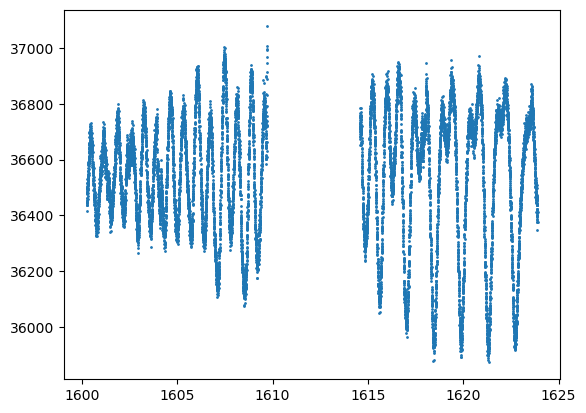

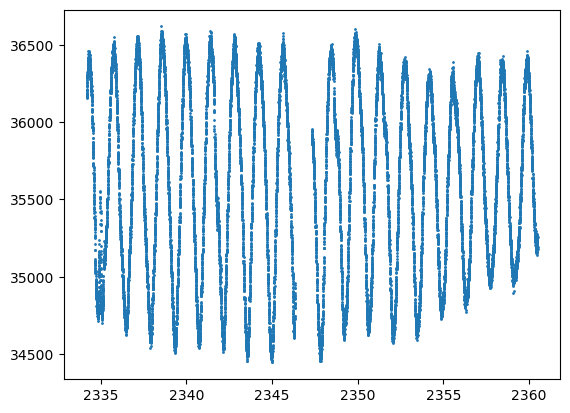

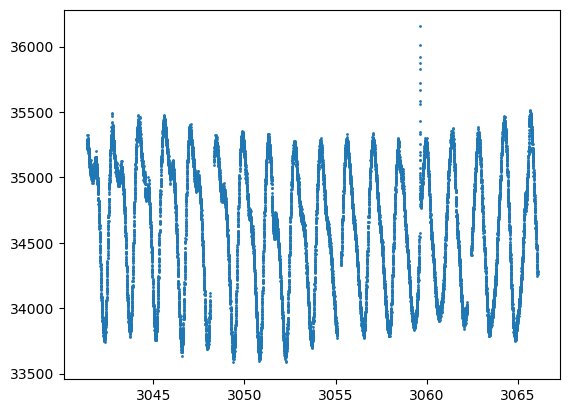

In [32]:
%matplotlib inline
for lc in lcs:
    plt.figure()
    plt.scatter(lc.time.value, lc.flux.value, s=1)
    # plt.xlim(2355, 2356)
    # plt.xlim(3045,3046)
    # plt.ylim(34500, 35500)

Period: 0.7082857476218837 d
Period: 1.4143296161613204 d
Period: 1.4210044466144294 d


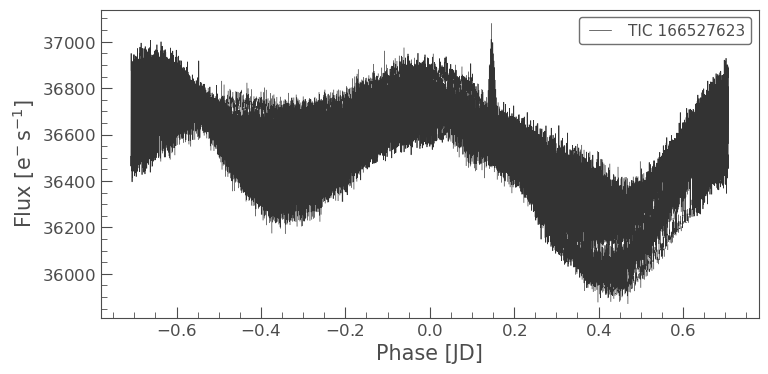

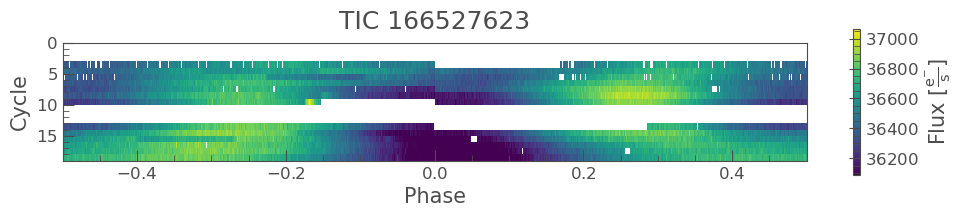

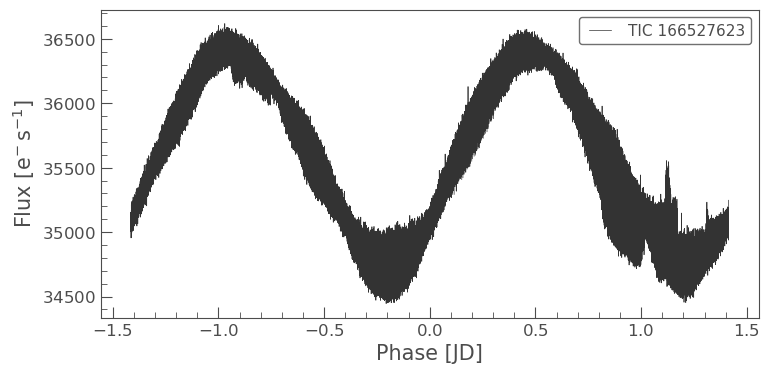

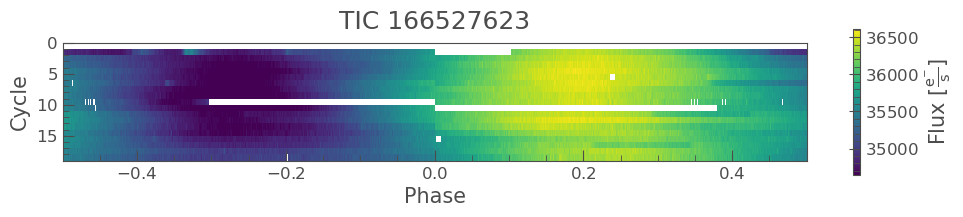

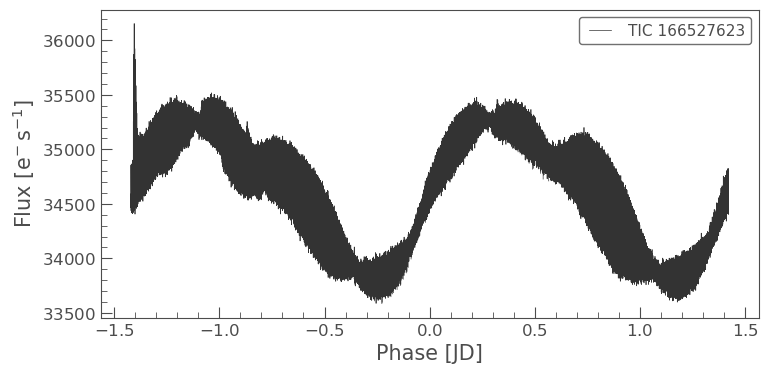

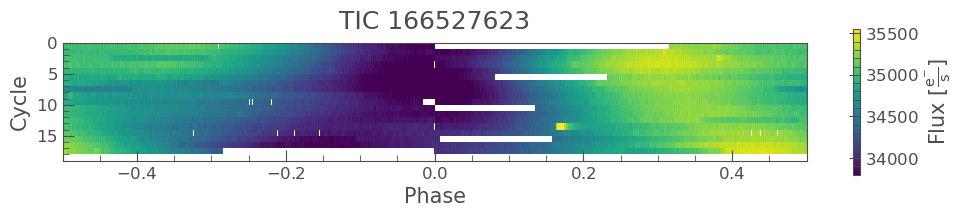

In [20]:
# find main period in each Ofer Cohenlight curve, fold andp plot
%matplotlib inline
for lc in lcs:
    pg = lc.to_periodogram()
    period = pg.period_at_max_power
    print(f"Period: {period}")
    lc.fold(period.value*2).plot()
    # fig, ax = plt.subplots(figsize=(7,10))
    if period.value < 1:
        period = 2*period
    lc.plot_river(period, epoch_time=1600.)

Period: 0.7082857476218837 d
[ 5.84721251e-03  1.12245537e+00 -1.34541636e-04  5.95633492e+00
  9.98870812e-01]


  0%|          | 0/5000 [00:00<?, ?it/s]/home/ilin/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:01<00:00, 3636.83it/s]


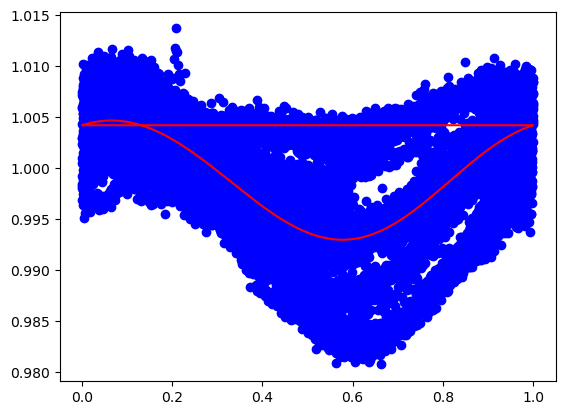

In [18]:
lc = lcs[0]

pg = lc.to_periodogram()
period = pg.period_at_max_power
print(f"Period: {period}")
folded_lc = lc.fold(period.value)

# write a two sine fit
def func(x, a1, p1, a2, p2, off):
    return a1 * np.sin(2 * np.pi * x + p1) + a2 * np.sin(4 * np.pi * x  + p2) + off

from scipy.optimize import curve_fit

pphase = (folded_lc.time.value / period.value) % 1
pflux = folded_lc.flux.value

# mask nans
mask = np.isnan(pflux)
pphase = pphase[~mask]
pflux = pflux[~mask]

pflux = pflux / np.median(pflux)

popt, pcov = curve_fit(func, pphase, pflux, p0=[0.03, 1.5, 0.02, 5, 0.005])
print(popt)
plt.plot(pphase, func(pphase, *popt), "r-")
plt.scatter(pphase, pflux, c="b")

# make an mcmc fit
import emcee

def log_likelihood(theta, x, y, yerr):
    a1, p1, a2, p2, off = theta
    model = func(x, a1, p1, a2, p2, off)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    a1, p1, a2, p2, off = theta
    if 0 < a1 < 0.1 and 0 < a2 < 0.1 and 0 < p1 < 2 * np.pi and 0 < p2 < 2 * np.pi and -0.1 < off < 0.1:
        return 0.0
    return -np.inf


def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

nwalkers, ndim = 32, 5
pos = popt + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(pphase, pflux, 0.001))
sampler.run_mcmc(pos, 5000, progress=True);


/tmp/ipykernel_4886/702403706.py:25: RuntimeWarning: Mean of empty slice.
  binned_phase = np.array([phase[inds == i].mean() for i in range(1, len(bins))])


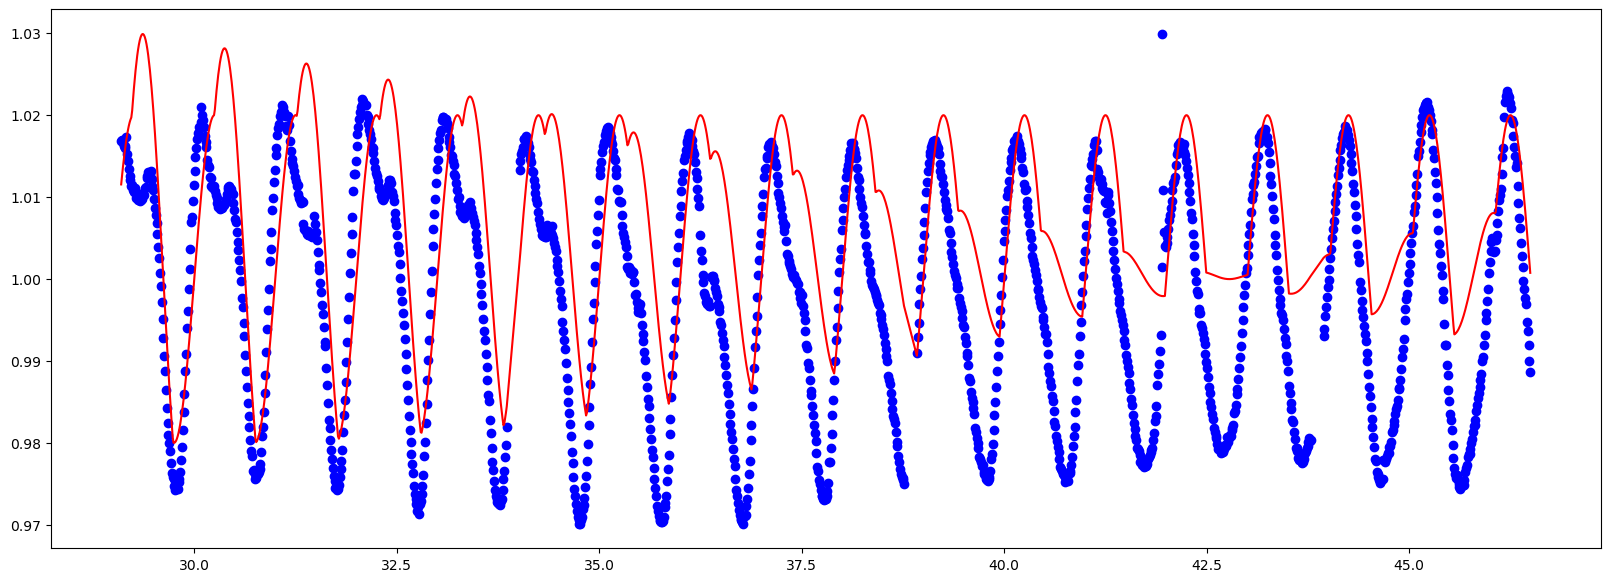

In [197]:
# make a light curve made of two sine waves with slightly different periods and amplitudes

def func(x, a1, p1, a2, p2, off, f):
    c1 = a1 * np.sin(2 * np.pi * x + p1) 
    c2 = a2 * np.sin(2 * np.pi * x * f  + p2) 
    c2[c2 < 0] = 0
    return c1 + c2 + off

lc = lcs[2]

pg = lc.to_periodogram()
period = pg.period_at_max_power

phase = ((lc.time.value - 3000.) / period.value) 
pflux = lc.flux.value / np.median(lc.flux.value)




# bin the data in 15 minute intervals
# bin the data by averaging every 10 minutes
binsize = 15 / 60 / 24
bins = np.arange(phase.min(), phase.max(), binsize)
inds = np.digitize(phase, bins)
binned_phase = np.array([phase[inds == i].mean() for i in range(1, len(bins))])
binned_flux = np.array([pflux[inds == i].mean() for i in range(1, len(bins))])

mask = np.isnan(binned_flux)
# mask flare 2153.05, 2153.24
mask = np.isnan(binned_flux) #| ((binned_phase > 35))# & (binned_phase < 2153.24)))
binned_phase = binned_phase[~mask]
binned_flux = binned_flux[~mask]

# fit func to light curve)


plt.figure(figsize=(20,7))
plt.scatter(binned_phase, binned_flux, c="b")
# plt.plot(phase, func(phase, *popt), "r-")
popt = [0.02, 6.2831853 , 0.02, 2.23785631, 1. ,  0.98]
plt.plot(binned_phase, func(binned_phase, *popt), "r-")

#plot each sine wave

In [198]:
#emcee fit
def log_likelihood(theta, x, y, yerr):
    a1, p1, a2, p2, off, f = theta
    model = func(x, a1, p1, a2, p2, off, f)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    a1, p1, a2, p2, off, f = theta
    if (0 < a1 < 0.1) and (0 < a2 < 0.1) and (-2* np.pi < p1 < 2 * np.pi) and (-2* np.pi < p2 < 2 * np.pi) and (-1 < off < 1) and (0.9 < f < 1.0):
        return 0.0
    return -np.inf


def log_probability(theta, x, y, yerr):

    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

nwalkers, ndim = 32, 6
pos = popt + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(binned_phase, binned_flux, 0.0001))
sampler.run_mcmc(pos, 50000, progress=True);

  0%|          | 0/50000 [00:00<?, ?it/s]/home/ilin/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [01:28<00:00, 566.66it/s]


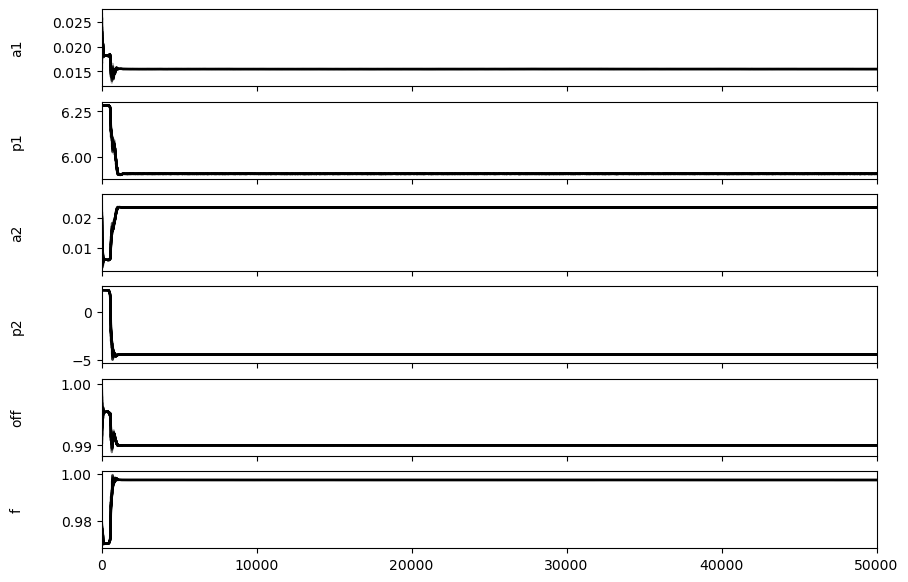

In [199]:
#plot chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a1", "p1", "a2", "p2", "off", "f"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

# bst value


array([ 0.01549798,  5.90758002,  0.02335303, -4.4471018 ,  0.99003531,
        0.99740031])

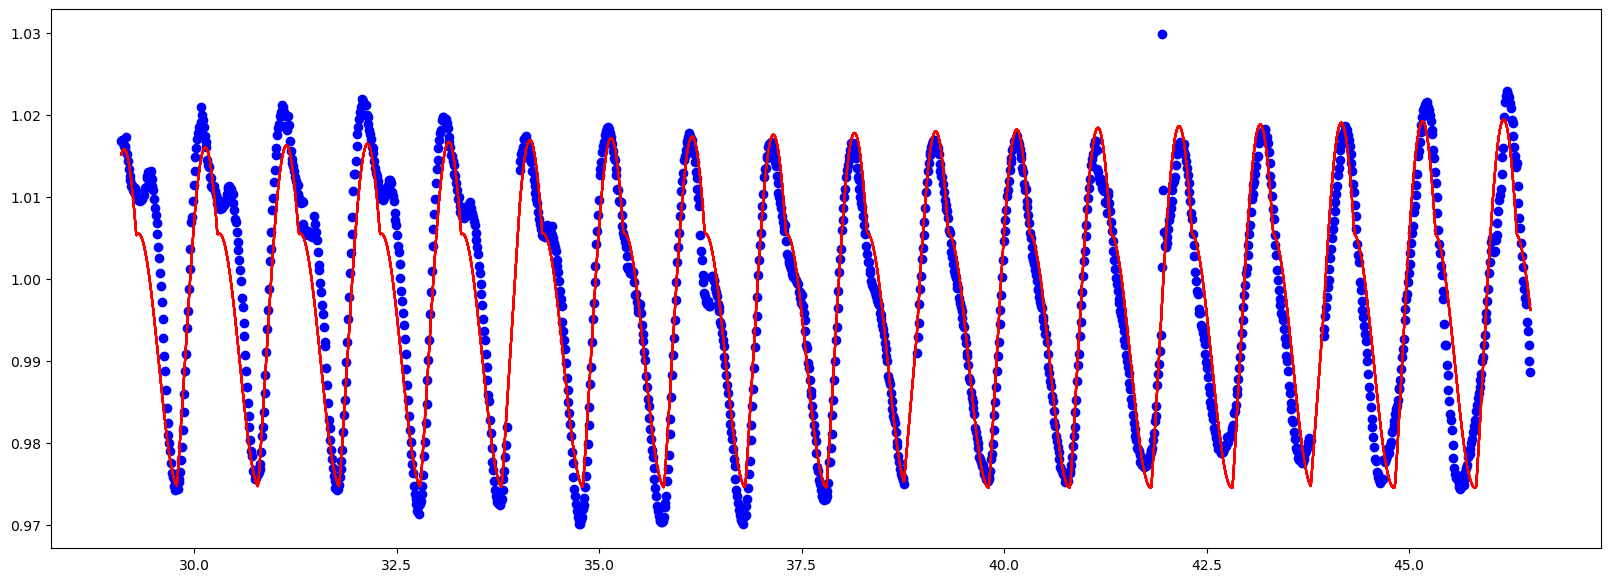

In [200]:
# plot best fits
samples = sampler.get_chain(discard=40000, flat=True) 
plt.figure(figsize=(20,7))
plt.scatter(binned_phase, binned_flux, c="b")

for i in range(100):
    ind = np.random.randint(len(samples))
    sample = samples[ind]
    # print(sample)
    plt.plot(binned_phase, func(binned_phase, *sample[:6]), "r", alpha=0.1)

# maximum likelihood from samples with emcee fit
max_ind = np.argmax(sampler.get_log_prob())
best_sample = sampler.get_chain(flat=True)[max_ind]


# plt.xlim(2147, 2148.5)

best_sample

(2153.0, 2153.3)

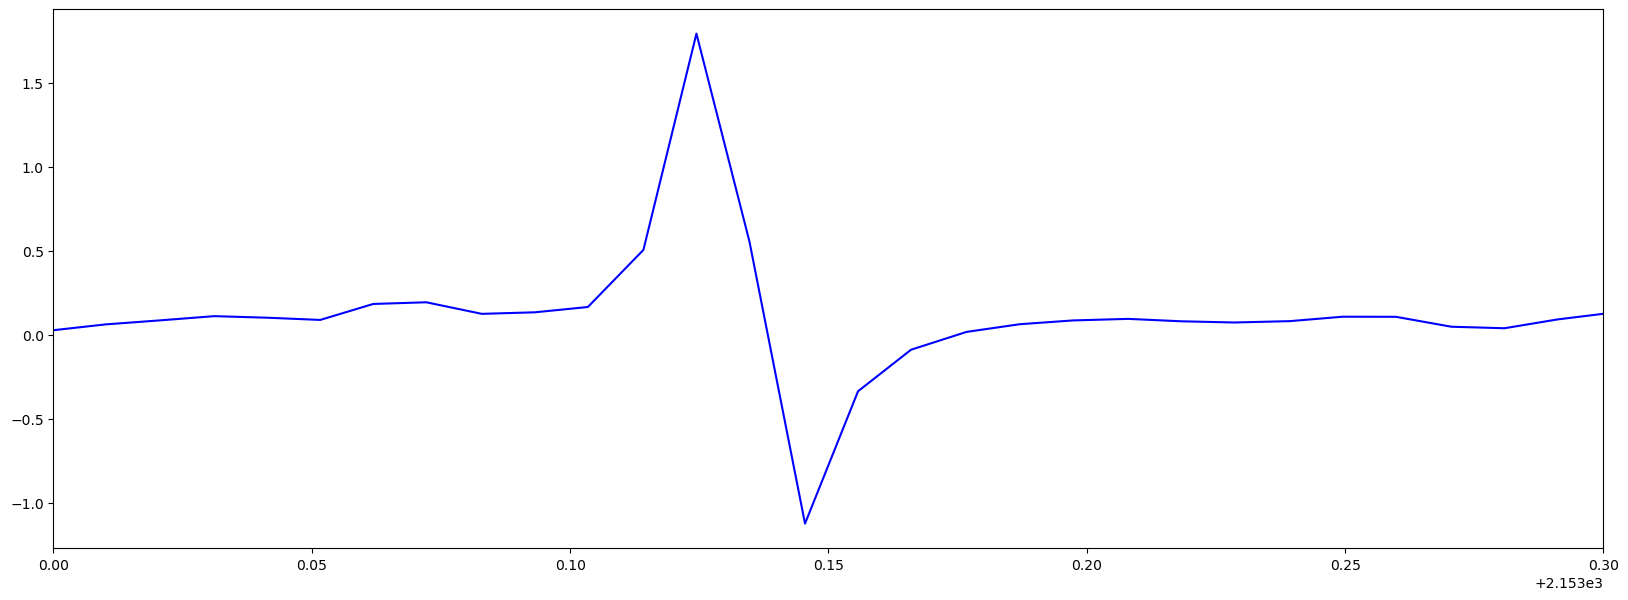

In [128]:
# calculate the derivative of the light curve
grad = np.gradient(binned_flux, binned_phase)
plt.figure(figsize=(20,7))
plt.plot(binned_phase, grad, "b-")
# plt.plot(binned_phase, func(binned_phase, *popt)[:len(binned_phase)], "r-")

plt.xlim(2153.05, 2153.24)

In [2]:
def create_spherical_grid(num_pts):
    """Method see:
    https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere
    answered by CR Drost

    Coversion to cartesian coordinates:
    x = np.cos(theta) * np.sin(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(phi);

    Parameters:
    -----------
    num_pts : int
        number of grid points on the full sphere

    Return:
    --------
    phi, theta - numpy arrays of latitude, longitude
    """

    # This is CR Drost's solution to the sunflower spiral:
    indices = np.arange(0, num_pts, dtype=float) + 0.5
    phi = np.arccos(1 - 2 * indices/num_pts) #latitude
    theta = np.pi * (1 + 5**0.5) * indices #longitude

    # # Fold onto on sphere
    # phi = (np.pi/2 - phi) % (2 * np.pi) # 0th  stars at the equator
    # # 2nd quadrant
    # q = np.where((np.pi/2 < phi) & (phi < np.pi))
    # phi[q] = np.pi-phi[q]
    # # 3rd quadrant
    # q = np.where((np.pi < phi) & (1.5*np.pi > phi))
    # phi[q] = -(phi[q] - np.pi)
    # # 4th quadrant
    # q = np.where((1.5*np.pi < phi) & (2*np.pi > phi))
    # phi[q] = phi[q] - np.pi*2
    # theta = theta % (np.pi * 2)

    return phi, theta

# select spot at a given latitude and longitude with a given radius
def select_spot(theta, phi, lat, lon, radius):
    """Selects a spot on the sphere with a given latitude, longitude and radius
    Parameters:
    -----------
    phi : numpy array
        latitude
    theta : numpy array
        longitude
    lat : float
        latitude of the spot
    lon : float
        longitude of the spot
    radius : float
        radius of the spot

    Return:
    -------
    mask : numpy array
        mask of the spot
    """
    # calculate the distance from the spot
   
    d = np.arccos(np.sin(lat) * np.sin(theta) + np.cos(lat) * np.cos(theta) * np.cos(lon-phi))
   

    return d < radius


def lightcurve_val(spot_mask, x):
    """apply geometric foreshortening to the spot mask"""

    # remove the mask from all points where x<0
    spot_mask[x < 0] = False

    return x[spot_mask].sum() / spot_mask.shape[0]


def lightcurve(lat, lons, theta, phi):

    x = np.cos(phi) * np.cos(theta)
    # for each longitude, calculate the spot mask, and lighturve value
    return [1. - lightcurve_val(select_spot(theta, phi, lat, lon, 0.1), x)   for lon in lons]


Text(0.5, 0, 'X')

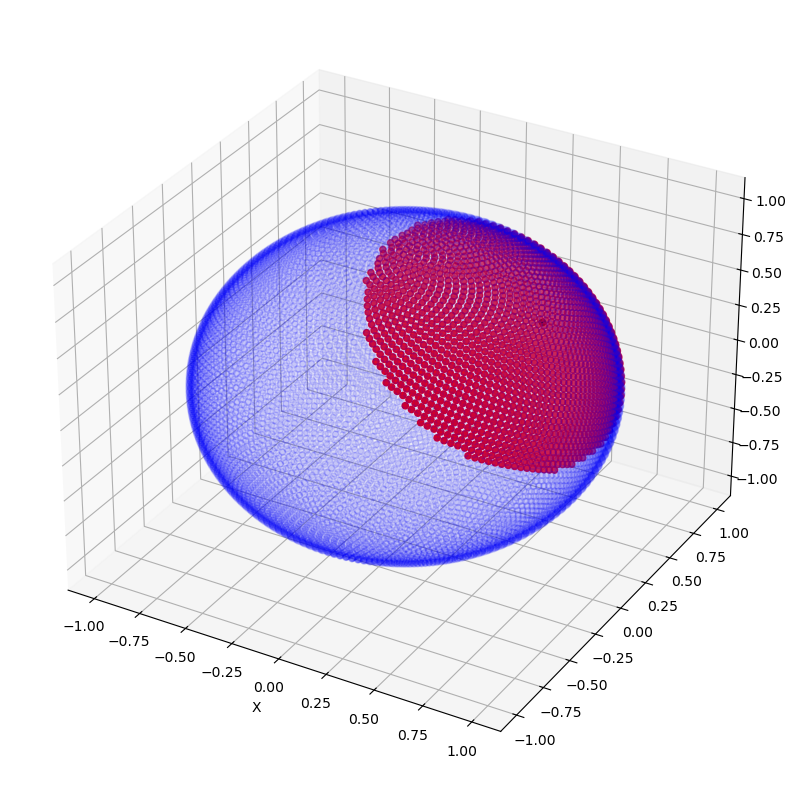

In [3]:
theta, phi = create_spherical_grid(10000) # theta is latitude comping from the north pole, phi is longitude 
phi = phi%(2*np.pi)
theta = np.pi/2 - theta


lon, lat = 2*np.pi, np.pi/4
spot_mask = select_spot(theta, phi, lat, lon, 0.85)

# convert lon and lat to x y z

x, y, z = np.cos(lon) * np.cos(lat), np.sin(lon) * np.cos(lat), np.sin(lat)


# replot on a 3d grid
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.cos(phi) * np.cos(theta), np.sin(phi) * np.cos(theta), np.sin(theta), c="b", alpha=0.1)
ax.scatter(np.cos(phi[spot_mask]) * np.cos(theta[spot_mask]), np.sin(phi[spot_mask]) * np.cos(theta[spot_mask]), np.sin(theta[spot_mask]), c="r")
ax.scatter(x, y, z, c="k")
# label the axes
ax.set_xlabel('X')

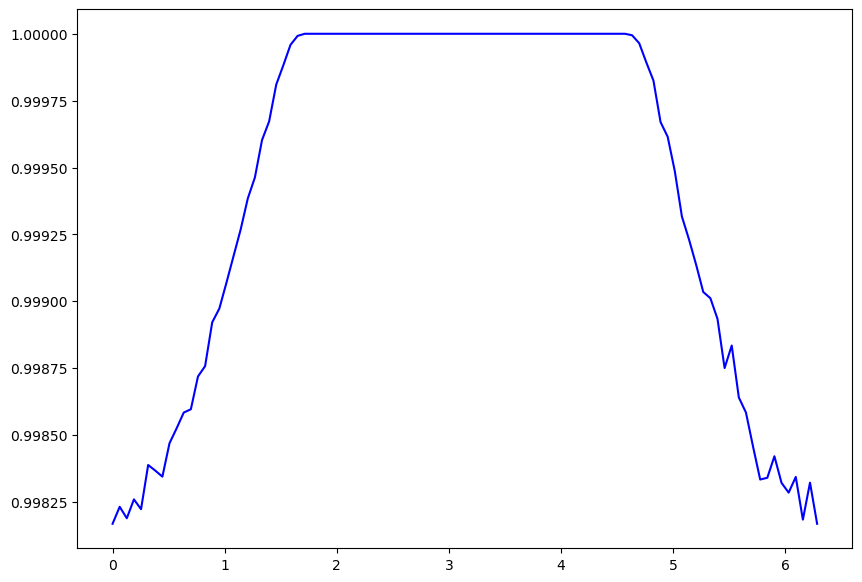

In [4]:
lons = np.linspace(0, 2*np.pi, 100)
lc = lightcurve(lat, lons, theta, phi)
plt.figure(figsize=(10,7))
plt.plot(lons, lc, "b-")

In [5]:
lats, lons, radii = [0.3, 1.2], [0, np.pi], [0.1, 0.3]
# reshape the above as 2d arrays with 2,1 shape
lats = np.array(lats).reshape(-1, 1)
lons = np.array(lons).reshape(-1, 1)
radii = np.array(radii).reshape(-1, 1)


phases = np.linspace(0, 6*np.pi, 200)

x = np.cos(phi) * np.cos(theta)
lc = np.zeros_like(phases)
for i, phase in enumerate(phases):
    spot_mask = select_spot(theta, phi, lats, (lons + phase) % (np.pi * 2), radii)
    spot_mask = spot_mask.sum(axis=0) > 0
    
    lc[i] = 1- lightcurve_val(spot_mask, x)

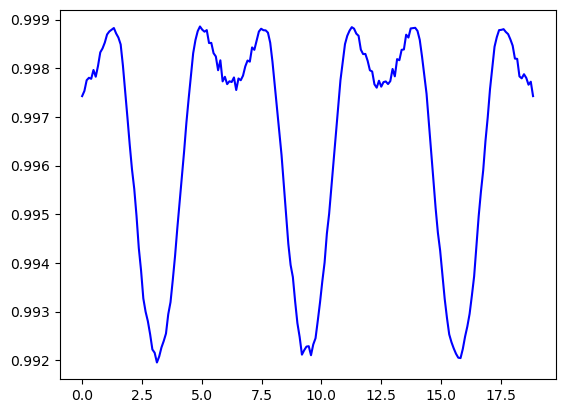

In [6]:
plt.plot(phases, lc, "b-")

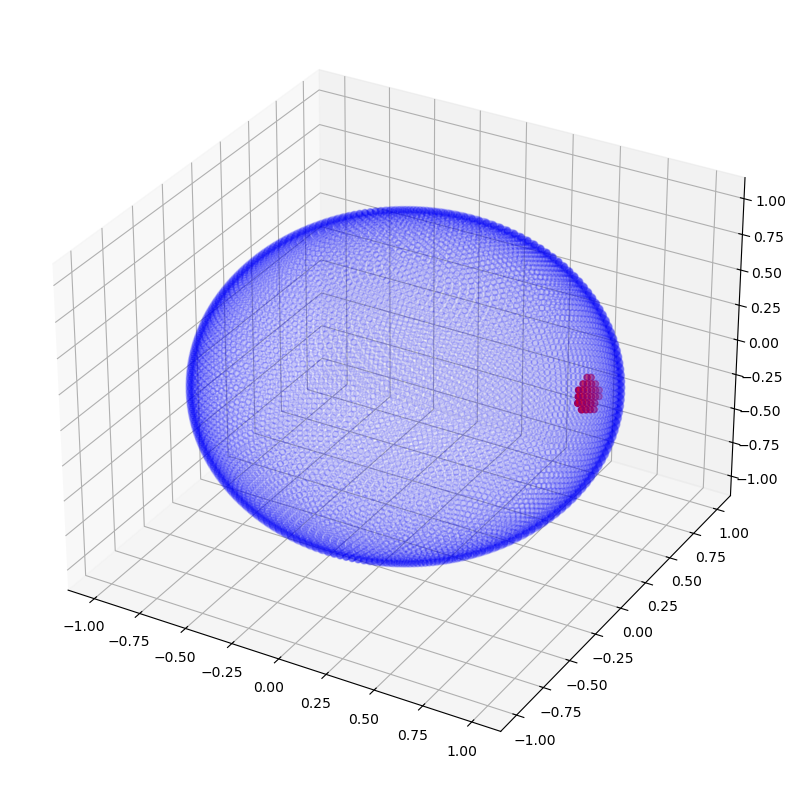

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.cos(phi) * np.cos(theta), np.sin(phi) * np.cos(theta), np.sin(theta), c="b", alpha=0.1)
ax.scatter(np.cos(phi[spot_mask]) * np.cos(theta[spot_mask]), np.sin(phi[spot_mask]) * np.cos(theta[spot_mask]), np.sin(theta[spot_mask]), c="r")


In [71]:


def select_spot(lat, lon, radius, stheta, ctheta, sphi, cphi):
    """Selects a spot on the sphere with a given latitude, longitude and radius
    Parameters:
    -----------
    phi : numpy array
        latitude
    theta : numpy array
        longitude
    lat : float
        latitude of the spot
    lon : float
        longitude of the spot
    radius : float
        radius of the spot

    Return:
    -------
    mask : numpy array
        mask of the spot
    """
    # calculate the distance from the spot
    clon_phi = np.cos(lon) * cphi + np.sin(lon) * sphi
    d = np.arccos(np.sin(lat) * stheta + np.cos(lat) * ctheta * clon_phi)

    return d < radius


def lightcurve_val(spot_mask, x, n, ld=False, spot_contrast=0.8):
    """Apply geometric foreshortening to the spot mask.
    
    All arrays have the shape (len(time), n)
    """
    # Calculate the lightcurve value
    if ld:
        x[~spot_mask] = x[~spot_mask] * (1 - 0.22 * (1 - np.sqrt(1 - x[~spot_mask]**2)) - 0.27 * (1 - np.sqrt(1 - x[~spot_mask]**2))**2)
        x[spot_mask] = x[spot_mask] * spot_contrast * (1 - 0.22 * (1 - np.sqrt(1 - x[spot_mask]**2)) - 0.27 * (1 - np.sqrt(1 - x[spot_mask]**2))**2)
    else:
        x[~spot_mask] = 1
        x[spot_mask] = spot_contrast
    
    return np.sum(x, axis=1) / n * 2
  

def lightcurve(lat, lons, radius, x, n, stheta, ctheta, sphi, cphi, **kwargs):
  
    
    # Vectorize the computation over all longitudes
    spot_masks = np.array([select_spot(lat, lon, radius, stheta, ctheta, sphi, cphi) for lon in lons])

    return lightcurve_val(spot_masks, x, n, **kwargs)


def create_lightcurve(time, latitudes, longitudes, periods, radii, theta, phi, n, stheta, ctheta, sphi, cphi, **kwargs):


    lc = np.zeros_like(time)
    
    # Precompute some values
    num_lons = len(longitudes)


    # Precompute phases for all longitudes
    all_phases = (longitudes[:, None] + time / periods[:, None] * 2 * np.pi) % (2 * np.pi)

    
    for i in range(num_lons):

        x = np.cos(phi) * np.cos(theta)

        # broadcast x to the shape of the spot_masks
        x = np.broadcast_to(x, (len(time), n)).copy()
    
        lat = latitudes[i]
        radius = radii[i]
        phases = all_phases[i]


        # Calculate lightcurves for all longitudes
        lcadd = lightcurve(lat, phases, radius, x, n, stheta, ctheta, sphi, cphi, **kwargs)

        lc += lcadd
    
    return lc / num_lons 


time = np.linspace(0,10,2000)
latitudes = np.array([0.3, 1.4])
longitudes = np.array([0.3, 4.3])
periods = np.array([1.43, 1.45])
radii = np.array([0.2, 0.4])
n = 30000
theta, phi = create_spherical_grid(n)  # theta is latitude coming from the north pole, phi is longitude
phi %= 2 * np.pi
theta = np.pi / 2 - theta
x = np.cos(phi) * np.cos(theta)

phi = phi[x > 0]
theta = theta[x > 0]

stheta, ctheta = np.sin(theta), np.cos(theta)
sphi, cphi = np.sin(phi), np.cos(phi)


n = len(phi)

# %timeit create_lightcurve(time, latitudes, longitudes, periods, radii, theta, phi, n)
lc = create_lightcurve(time, latitudes, longitudes, periods, radii, theta, phi, n, stheta, ctheta, sphi, cphi)

parameters = [*latitudes, *longitudes, *periods, *radii]

parameters

[0.3, 1.4, 0.3, 4.3, 1.43, 1.45, 0.2, 0.4]

10000 x 2000 x 2 spots

773 ms ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

629 ms ± 43.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

623 ms ± 24.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

387 ms ± 32.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

240 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

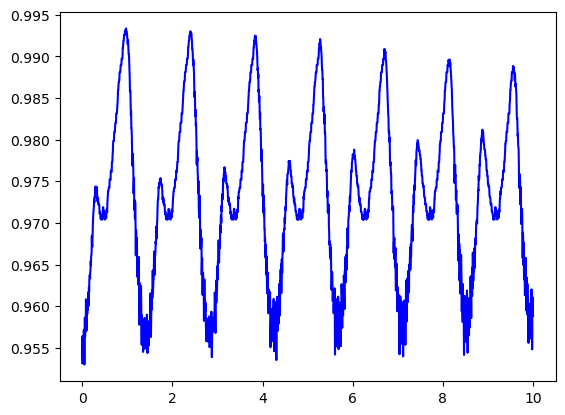

In [21]:

plt.plot(time, lc, "b-")

In [56]:
lcs = lk.search_lightcurve('HIP 67522', author='SPOC', exptime="120")
data = lcs[-1].download()
time, flux = data.time.value, data.flux.value

In [57]:
# bin the data in 15 minute intervals
# bin the data by averaging every 10 minutes
binsize = 30 / 60 / 24
bins = np.arange(time.min(), time.max(), binsize)
inds = np.digitize(time, bins)
binned_phase = np.array([time[inds == i].mean() for i in range(1, len(bins))])
binned_flux = np.array([flux[inds == i].mean() for i in range(1, len(bins))])

mask = np.isfinite(binned_flux) #& (binned_phase<3050)
binned_phase = binned_phase[mask]
binned_flux = binned_flux[mask]

# divide the flux by the median
binned_flux = binned_flux / np.median(binned_flux)

# shift time by 3030
binned_phase = binned_phase - 3030



/tmp/ipykernel_4869/37497814.py:6: RuntimeWarning: Mean of empty slice.
  binned_phase = np.array([time[inds == i].mean() for i in range(1, len(bins))])
/home/ilin/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(True, True, True, True, True, True, True, True, True)

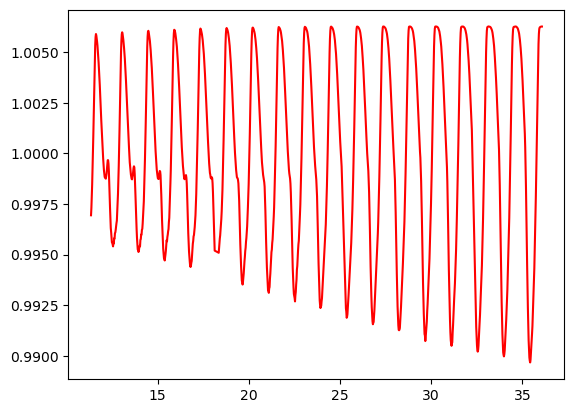

In [83]:
# plt.plot(binned_phase, binned_flux, "b-")
latitudes = np.array([0.5,1.3])
longitudes = np.array([1,4])
periods = np.array([1.43, 1.45])
radii = np.array([0.225, 0.325])
offset = 0.015
model = create_lightcurve(binned_phase, latitudes, longitudes, periods, 
                          radii, theta, phi, n, stheta, ctheta, sphi, cphi, **{"ld":True, "spot_contrast":0.5}) + offset

plt.plot(binned_phase, model / np.median(model), "r-")

parameters = [*latitudes, *longitudes, *periods, *radii, offset]
parameters

lat1, lat2, lon1, lon2, p1, p2, r1, r2, off = parameters
(0 < lat1 < np.pi/2), (0 < lat2 < np.pi/2), (0 < lon1 < (2 * np.pi)), (0 < lon2 < (2 * np.pi)), (0 < p1 < 2), (0 < p2 < 2), (0 < r1 < 1), (0 < r2 < 1), (-1 < off < 1)

In [26]:
# emcee fit to the light curve
import emcee
def log_likelihood(ps, x, y, yerr):
    lat1, lat2, lon1, lon2, p1, p2, r1, r2, off = ps
    model = create_lightcurve(x, np.array([lat1, lat2]), np.array([lon1, lon2]), 
                              np.array([p1, p2]), np.array([r1, r2]), theta, phi, n, stheta, ctheta, sphi, cphi) + off
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(ps):
    lat1, lat2, lon1, lon2, p1, p2, r1, r2, off = ps
    if ((0 < lat1 < np.pi/2) and 
        (0 < lat2 < np.pi/2) and 
        (0 < lon1 < (2 * np.pi)) and 
        (0 < lon2 < (2 * np.pi)) and 
        (0 < p1 < 2) and 
        (0 < p2 < 2) and 
        (0 < r1 < 1) and 
        (0 < r2 < 1) and
        (-1 < off < 1)):
        return 0.0
    return -np.inf

def log_probability(ps, x, y, yerr):
    lp = log_prior(ps)
  
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(ps, x, y, yerr)

nwalkers, ndim = 32, 9
pos = np.array(parameters) + 1e-2 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(binned_phase, binned_flux, 0.0001))
sampler.run_mcmc(pos, 5000, progress=True);


100%|██████████| 5000/5000 [22:32<00:00,  3.70it/s]


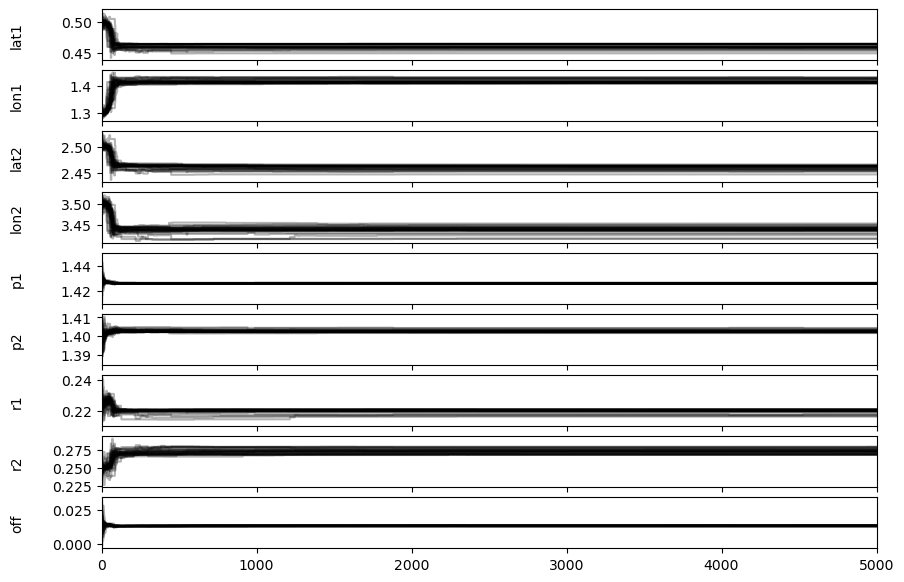

In [27]:
#plot chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["lat1", "lon1", "lat2", "lon2", "p1", "p2", "r1", "r2", "off"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

In [28]:
# best value
samples = sampler.get_chain(discard=4000, flat=True)
best_sample = np.median(samples, axis=0)
best_sample


array([0.45928041, 1.41405977, 2.46189961, 3.43941861, 1.42633314,
       1.40249214, 0.22038503, 0.27290371, 0.01322155])

array([0.45253697, 1.43066801, 2.45180794, 3.4174328 , 1.42635592,
       1.40343869, 0.21653182, 0.27801266, 0.01287686])

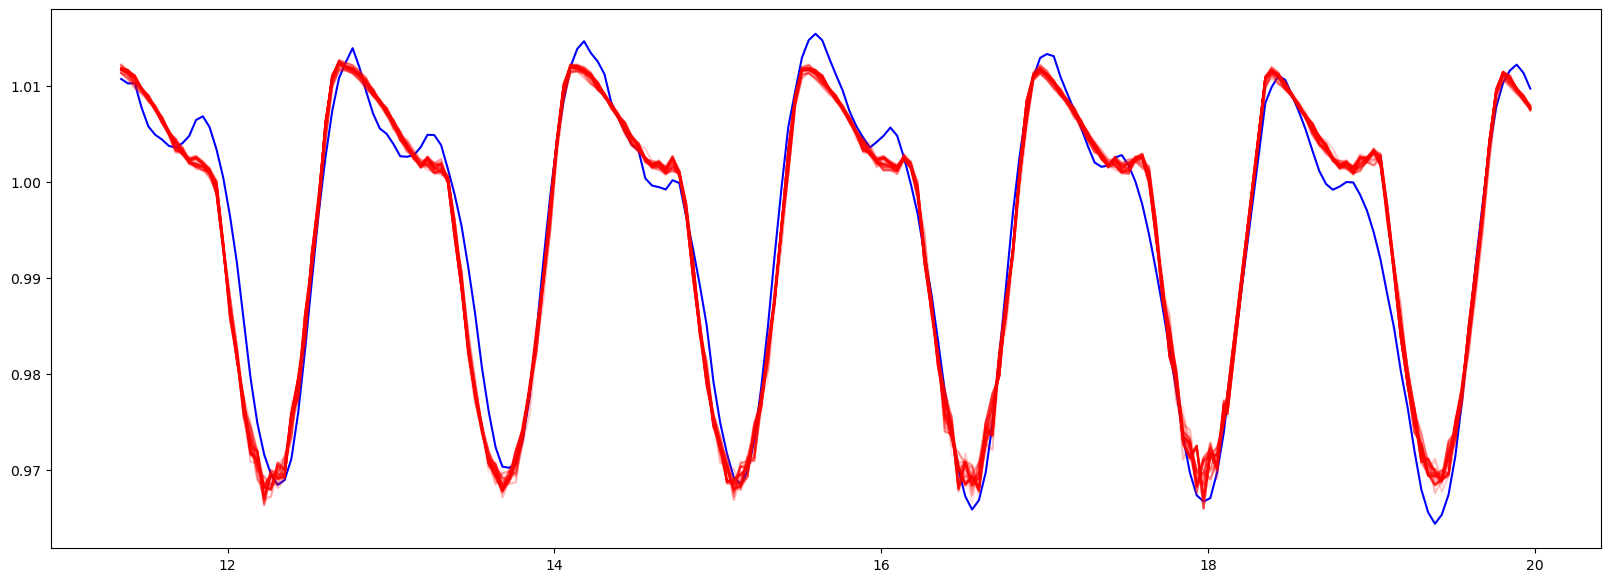

In [30]:
# plot best fits
plt.figure(figsize=(20,7))
plt.plot(binned_phase, binned_flux, "b-")

for i in range(100):
    ind = np.random.randint(len(samples))
    sample = samples[ind]
    # print(sample)
    plt.plot(binned_phase, create_lightcurve(binned_phase, sample[0:2], sample[2:4], sample[4:6], sample[6:8],
                                              theta, phi, n, stheta, ctheta, sphi, cphi) + sample[8], "r", alpha=0.1)

# maximum likelihood from samples with emcee fit
max_ind = np.argmax(sampler.get_log_prob())
best_sample = sampler.get_chain(flat=True)[max_ind]

best_sample


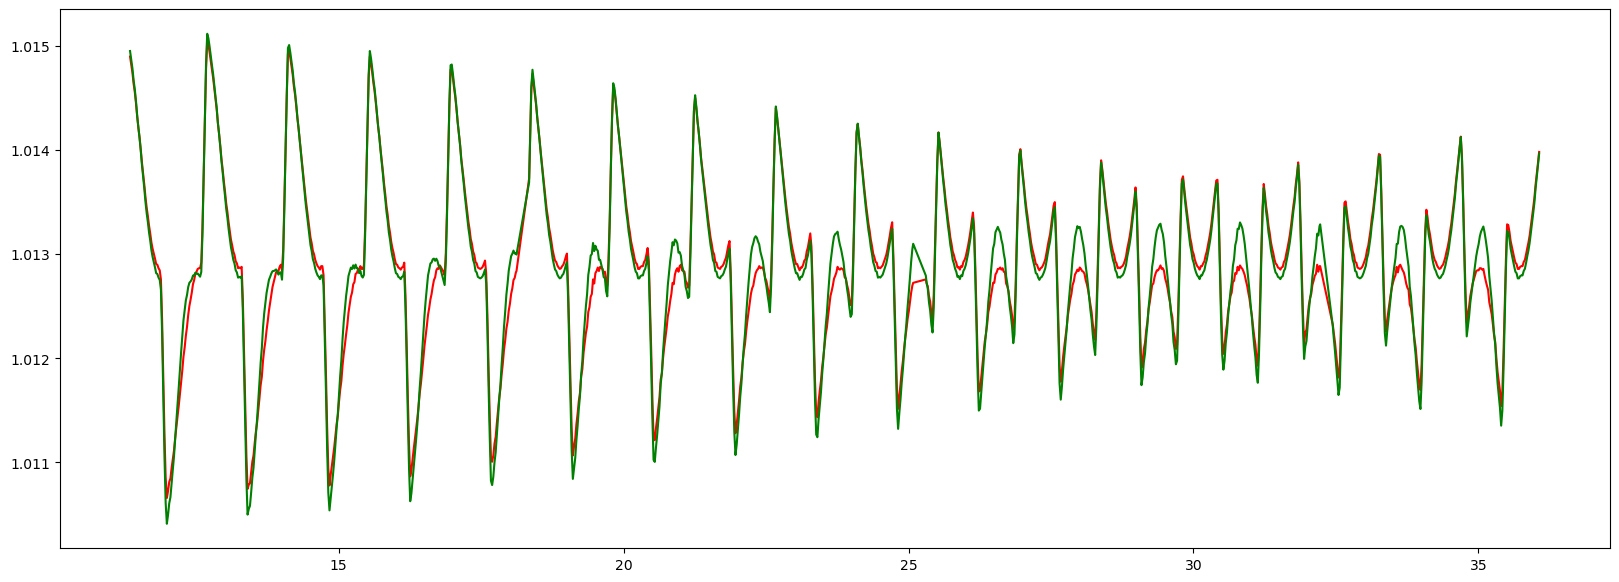

In [58]:
# plot best sample against data
plt.figure(figsize=(20,7))
# plt.plot(binned_phase, binned_flux, "b-")
plt.plot(binned_phase, create_lightcurve(binned_phase, best_sample[0:2], best_sample[2:4], best_sample[4:6], best_sample[6:8],
                                         theta, phi, n, stheta, ctheta, sphi, cphi) + best_sample[8], "r-")
plt.plot(binned_phase, create_lightcurve(binned_phase, best_sample[0:2], best_sample[2:4], best_sample[4:6], best_sample[6:8],
                                         theta, phi, n, stheta, ctheta, sphi, cphi, **{"ld":True}) + best_sample[8], "g-")
# plt.xlim(15,20)

In [33]:
# fold the model with best_sample[4]

plt.plot(binned_phase, create_lightcurve(binned_phase, best_sample[0:2], best_sample[2:4], best_sample[4:6], best_sample[6:8],
                                            theta, phi, n, stheta, ctheta, sphi, cphi) + best_sample[8], "r-")



/tmp/ipykernel_4869/3770345822.py:12: RuntimeWarning: Mean of empty slice.
  binned_phase = np.array([lc.time.value[inds == i].mean() for i in range(1, len(bins))])
/home/ilin/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1.0 1.4270833333333333
2.0 2.8541666666666665
3.0072992700729926 4.291666666666667
4.029197080291971 5.75
5.087591240875913 7.260416666666667
6.153284671532846 8.78125
7.204379562043796 10.28125
8.248175182481752 11.770833333333334
9.255474452554745 13.208333333333334
10.248175182481752 14.625
11.24087591240876 16.041666666666668
12.226277372262773 17.447916666666668
13.218978102189782 18.864583333333332
14.211678832116789 20.28125
15.211678832116789 21.708333333333332
16.204379562043794 23.125


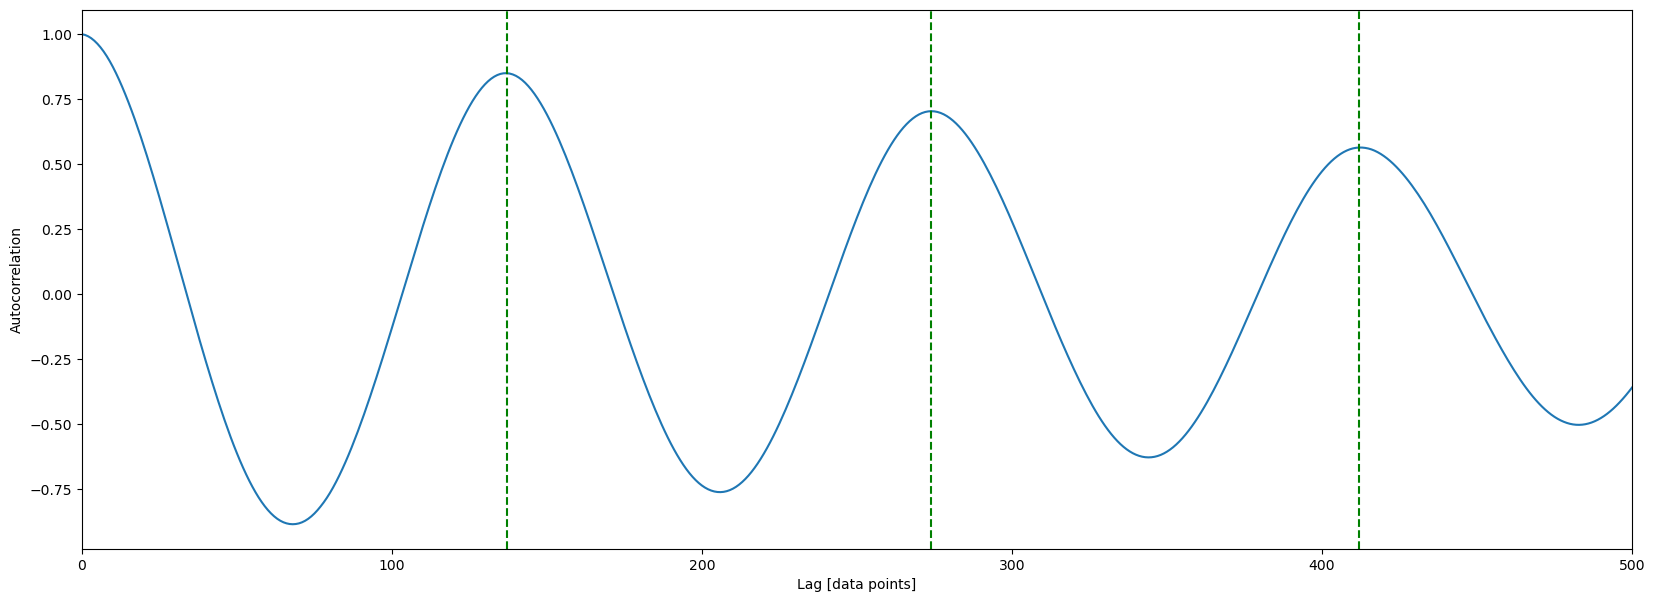

In [115]:
# compute the autocorrelation function of the tess light curve
from scipy.signal import correlate
from scipy.signal import find_peaks

lc = lk.search_lightcurve('HIP 67522', author='SPOC', exptime="120")[1].download()

# bin the data in 15 minute intervals
# bin the data by averaging every 10 minutes
binsize = 15 / 60 / 24
bins = np.arange(lc.time.value.min(), lc.time.value.max(), binsize)
inds = np.digitize(lc.time.value, bins)
binned_phase = np.array([lc.time.value[inds == i].mean() for i in range(1, len(bins))])
binned_flux = np.array([lc.flux.value[inds == i].mean() for i in range(1, len(bins))])

mask = np.isnan(binned_flux)
binned_phase = binned_phase[~mask]
binned_flux = binned_flux[~mask]


# compute the autocorrelation function
acf = correlate(binned_flux - np.mean(binned_flux), binned_flux - np.mean(binned_flux), mode="full")

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

acf = autocorr(binned_flux - np.mean(binned_flux))

acf = acf / np.max(acf)

# find the peaks
peaks, _ = find_peaks(acf, height=0.05)
peaks = peaks[acf[peaks] > 0.]

# plot the acf
plt.figure(figsize=(20,7))
plt.plot(acf)
plt.xlabel("Lag [data points]")
plt.ylabel("Autocorrelation")
plt.xlim(0, 500)

for peak in peaks:
    print(peak/peaks[0], peak*0.25/24)
    plt.axvline(peak, color="g", linestyle="--")

In [96]:
0.5/24 * 66.5

1.3854166666666665

In [ ]:
12: 0.7083, 1.4271
34: 1.4271
64: 1.3854166666666665

In [32]:
import pandas as pd
df = pd.read_csv("../data/hip67522_cheops.csv")

# remove the transits
import batman
# use batman to create a transit model
params = batman.TransitParams()

params.t0 = 1604.02344 + 56999.5             #time of inferior conjunction in BJD
params.per = 6.9594738               #orbital period
params.rp = 0.0668                      #planet radius (in units of stellar radii)
params.a = 11.74                       #semi-major axis (in units of stellar radii)
params.inc = 89.46                     #orbital inclination (in degrees)
params.ecc = 0.053                      #eccentricity
params.w = 199.1                       #longitude of periastron (in degrees)
params.u = [0.22, 0.27]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model

m = batman.TransitModel(params, df["time"].values)    #initializes model
transit = m.light_curve(params) - 1.
df["flux"] = df["flux"] - transit*np.median(df["flux"])

flares = pd.read_csv("../results/cheops_flares.csv")
flares["tmin"] = flares["tmin"] - 2400000.5
flares["tmax"] = flares["tmax"] - 2400000.5

# mask flares in df
# for i, flare in flares.iterrows():
#     mask = (df["time"] > flare["tmin"]) & (df["time"] < flare["tmax"])
#     df["flux"][mask] = np.nan


print(df.head())

#bin data in 30 min chunks
binsize = 5 / 60 / 24
bins = np.arange(df["time"].min(), df["time"].max(), binsize)
inds = np.digitize(df["time"], bins)
binned_phase = np.array([df["time"][inds == i].mean() for i in range(1, len(bins))])
binned_flux = np.array([df["flux"][inds == i].mean() for i in range(1, len(bins))])

mask = np.isnan(binned_flux)
binned_phase = binned_phase[~mask]
binned_flux = binned_flux[~mask]

           time          flux        error
0  60378.217269  2.537272e+06  1687.440197
1  60378.217385  2.538778e+06  1687.286295
2  60378.217501  2.535560e+06  1687.725706
3  60378.217617  2.533312e+06  1687.339593
4  60378.217733  2.532380e+06  1687.472461


5.326385504443375e-226


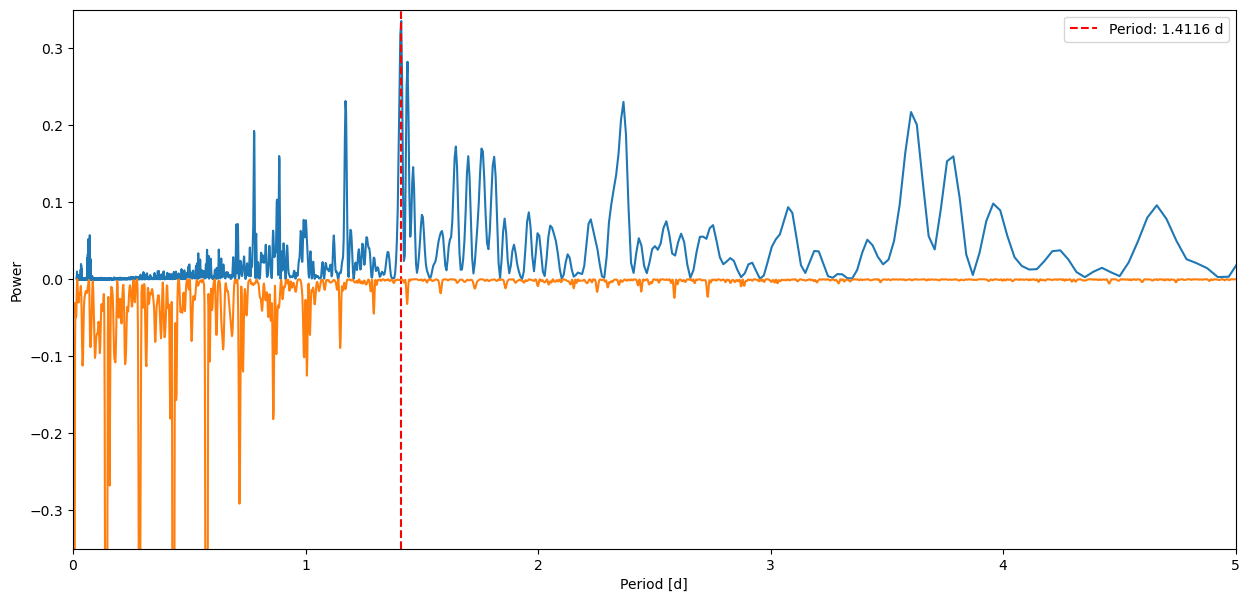

In [33]:
#lomb scargle periodogram
from astropy.timeseries import LombScargle
ls = LombScargle(binned_phase, binned_flux)
lswindow = LombScargle(binned_phase, np.ones_like(binned_flux))



plt.figure(figsize=(15,7))
frequency, power = ls.autopower()
plt.plot(1/frequency, power)
max_power = frequency[np.argmax(power)]
fap2 = ls.false_alarm_probability(np.max(power),method='single',
                                  method_kwds={'random_seed': 42, 'n_bootstraps': 10000})
print(fap2) 

plt.axvline(1/max_power, color="r", linestyle="--", label=f"Period: {1/max_power:.4f} d")

frequency, power = lswindow.autopower()
plt.plot(frequency, -power)
plt.xlabel("Period [d]")
plt.ylabel("Power")
plt.xlim(0, 5)
plt.ylim(-0.35, 0.35)
plt.legend()



(0.5, 0.7)

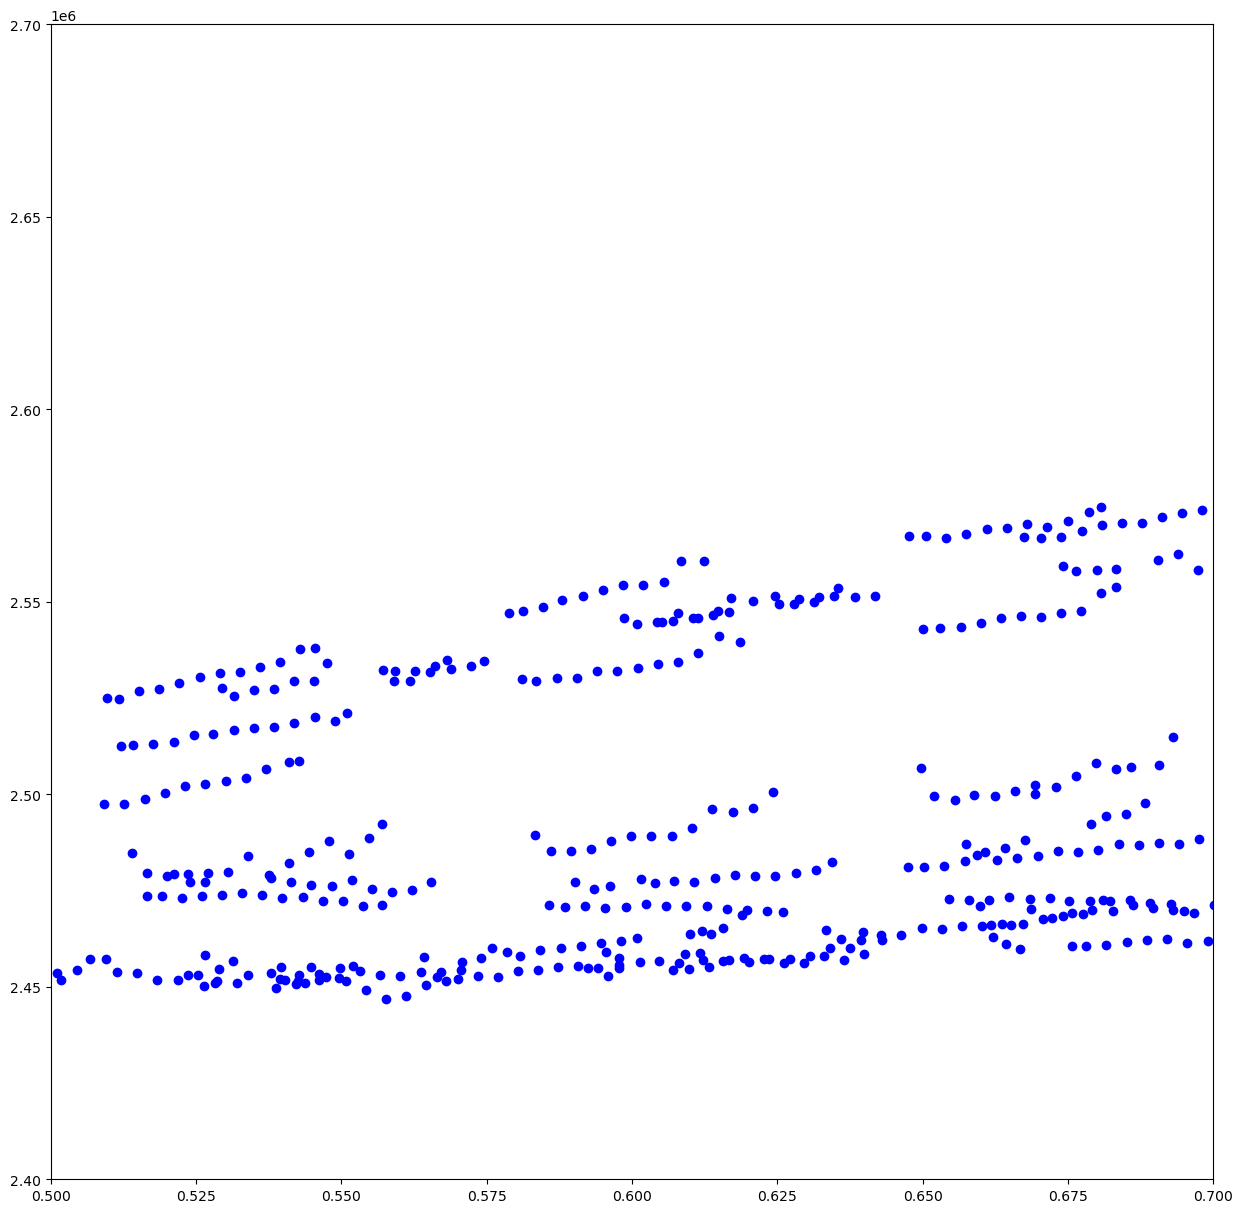

In [36]:
# fold the light curve at the period at max power
folded_phase = binned_phase % (1/max_power)
plt.figure(figsize=(15,15))
plt.scatter(folded_phase, binned_flux, c="b")

plt.fill_betweenx([2.4e6, 2.7e6], 0.55*(1/max_power), 0.6*(1/max_power), color="r", alpha=0.3)
plt.ylim(2.4e6, 2.7e6)
plt.xlim(0, 1/max_power)
plt.xlim(0.5,0.7)

60378.21726870647
2460377.7172687063
2460379.8611360667
2460384.754665703
2460389.629887401
2460391.6725950744
2460398.6191226477
2460405.163213015
2460410.9569597193
2460412.368825718
2460419.073753469
2460428.246444427
2460430.0275867432
2460433.0152903185
2460440.373289223
2460447.317269289
2460454.2781084324
2460456.1492125536
2460461.2655255897
2460468.2105600545
2460475.2409868776
2460482.090987388


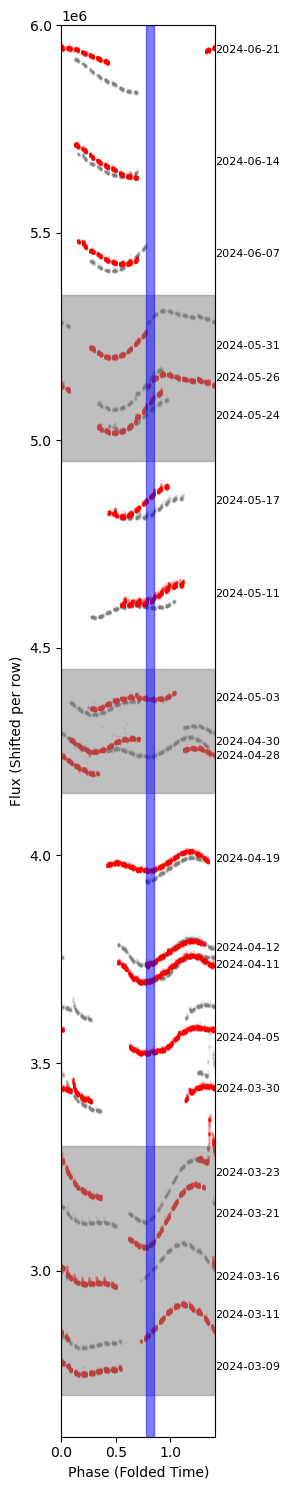

1.4116020156575695

In [37]:
# make a river plot of the light curve with the period at max power
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def make_river_plot(df, period, dates, figsize=(10, 6), lines=[]):
    """
    Creates a river plot of flux over time folded on a given period.

    Parameters:
    df (pd.DataFrame): DataFrame with 'time' and 'flux' columns.
    period (float): Period to fold the time over.
    num_bins (int): Number of phase bins for the river plot.
    figsize (tuple): Size of the figure.
    """
    # Extract time and flux from the dataframe
    time = df['time'].values
    flux = df['flux'].values
    T0 = time.min()
    i=0
    plt.figure(figsize=figsize)
    print(T0)
    mask = (time - T0) < period
    previoust = (time[mask] - T0) % period
    offset = (T0-60370)*0.03e6
    previousf = flux[mask] + offset

    # Compute the phase by folding the time with the given period
    while len(time) > 0:
        # take the first full rotation and plot it
        t0 = time.min()
        print(t0 + 2399999.5)

        mask = (time - t0) < period
        
        plt.scatter(previoust, previousf - offset + (t0-60370)*0.03e6, c="grey", alpha=0.01, s=1)
        previoust = (time[mask] - T0) % period
        offset = (t0-60370)*0.03e6
        previousf = flux[mask] + (t0-60370)*0.03e6
        plt.text(x=period, y=np.nanmean(previousf),s= dates[i], fontsize=8)
        
        plt.scatter(previoust, previousf, c="r", alpha=0.1, s=1)
        time = time[~mask]
        flux = flux[~mask]
        i+=1
        
    for linelow, linehigh in lines:
        # fill the region between the lines
        plt.fill_between([0, period], [linelow, linelow], [linehigh, linehigh], color="grey", alpha=0.5)

    plt.fill_betweenx([2.6e6, 6e6], 0.55 * period, 0.6 * period, color="blue", alpha=0.5)
    # Set plot labels and title
    plt.xlabel('Phase (Folded Time)')
    plt.ylabel('Flux (Shifted per row)')
    plt.xlim(0, period)  
    plt.ylim(2.6e6, 6e6)
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a DataFrame `df` with 'time' and 'flux' columns.
# period = 1.234  # Example period
# make_river_plot(df, period)


dates = [
"2024-03-09",
"2024-03-11",
"2024-03-16",
"2024-03-21",
"2024-03-23",
"2024-03-30",
"2024-04-05",
"2024-04-11",
"2024-04-12",
"2024-04-19",
"2024-04-28",
"2024-04-30",
"2024-05-03",
"2024-05-11",
"2024-05-17",
"2024-05-24",
"2024-05-26",
"2024-05-31",
"2024-06-07",
"2024-06-14",
"2024-06-21"]

lines = [(2.7e6, 3.3e6), (4.15e6, 4.45e6), (4.95e6, 5.35e6)]
make_river_plot(df, 1.4116, dates, figsize=(3,15), lines=lines)
1/max_power

In [1]:
time.min()

NameError: name 'time' is not defined